In [146]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [147]:
import numpy as np
import pandas as pd

In [148]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [149]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [150]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [151]:
Base = automap_base()
Base.prepare(engine, reflect=True)


In [152]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [153]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [154]:
# reflect an existing database into a new model
Measurement = Base.classes.measurement
Station = Base.classes.station

In [155]:
# reflect the tables
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f65e9f49e8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [156]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f65f60c198>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [157]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [158]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

In [159]:
# Calculate the date 1 year ago from the last data point in the database

session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [ ]:
# Perform a query to retrieve the data and precipitation scores


In [174]:
# Save the query results as a Pandas DataFrame and set the index to the date column

results = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).all()

In [194]:
# Sort the dataframe by date

df = pd.DataFrame(results[:2200], columns=['date', 'prcp'])
df.set_index('date', inplace=True, )
df.head(10)


,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-21,0.00
2017-08-21,0.02


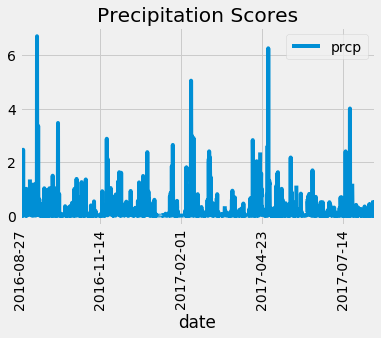

In [201]:
# Use Pandas Plotting with Matplotlib to plot the data

df.iloc[::-1].plot(title="Precipitation Scores")
plt.tight_layout()
plt.xticks(rotation="vertical")
plt.show()

In [203]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(Station.station)).all()

[(9)]

In [217]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [227]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

tobs_summ = [Measurement.station,
            func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.count(Measurement.tobs)]

temp_summ = session.query(*tobs_summ).filter(Measurement.station == 'USC00519281').all()
temp_summ

[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772)]

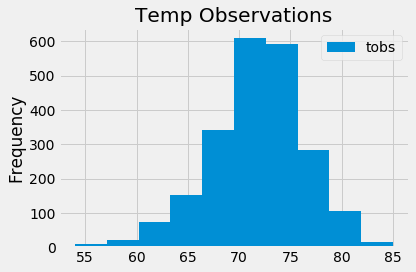

In [236]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


tobs_results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).all()

tobs_df = pd.DataFrame(tobs_results[:2200], columns=['tobs'])

tobs_df.iloc[::-1].plot.hist(title="Temp Observations")
plt.tight_layout()
plt.show()